In [ ]:
from qspectro2d.config import *  # provides CONFIG and mpl settings
from qutip import *

from thesis_paths import FIGURES_TESTS_DIR
name_plot_folder = "test_N_atoms_geometry"
custom_dir = FIGURES_TESTS_DIR / name_plot_folder

from plotstyle import COLORS, MARKERS, LINE_STYLES, save_fig, format_sci_notation, init_style
init_style()

In [11]:
# Test and visualize Gaussian inhomogeneity sampling
import numpy as np
import matplotlib.pyplot as plt
from typing import Optional, Tuple

from qspectro2d.spectroscopy.inhomogenity import normalized_gauss, sample_from_gaussian, _fwhm_to_sigma

def plot_gaussian_check(
    mu: float,
    fwhm: float,
    *,
    n_samples: int = 100_000,
    max_detuning: float = 10.0,
    bins: int = 200,
    ax: Optional[plt.Axes] = None,
    color: str = "C0",
    ls: str = "solid",
) -> Tuple[float, float]:
    """Draw samples and overlay with theoretical normalized Gaussian.

    Returns (sample_mean, sample_std).
    """
    # Sample
    samples      = sample_from_gaussian(n_samples, fwhm, mu, max_detuning=max_detuning)
    samples      = np.asarray(samples, dtype=float).ravel()

    # Stats
    mu_hat       = float(np.mean(samples))
    std_hat      = float(np.std(samples, ddof=1))
    sigma_theory = _fwhm_to_sigma(fwhm)

    # X-grid for theory
    x_min        = mu - 2 *fwhm
    x_max        = mu + 2 *fwhm
    x            = np.linspace(x_min, x_max, 1000)
    y            = normalized_gauss(x, fwhm=fwhm, mu=mu)

    # Plot
    if ax is None:
        _, ax = plt.subplots(figsize=(7, 4.5))
    ax.hist(
        samples,
        bins=bins,
        range=(x_min, x_max),
        density=True,
        color=color,
        histtype="step",
        linewidth=1.5,
        label=rf"samples ($n={n_samples}$)"
    )
    ax.plot(
        x,
        y,
        color=color,
        linestyle=ls,
        linewidth=2.0,
        label=rf"theory $\mathcal{{N}}(\mu={mu:.1f},\,\mathrm{{FWHM}}={fwhm:.1f})$"
    )

    # Labels
    ax.set_xlabel(r"Frequency $\nu$ (cm$^{-1}$)")
    ax.set_ylabel(r"Probability density")
    ax.set_title(
        rf"Gaussian samples vs. theory — $\mu={mu:.1f}$, FWHM={fwhm:.1f}, $\sigma_\mathrm{{th}}={sigma_theory:.2f}$; "
        rf"$\bar x={mu_hat:.2f}$, $s={std_hat:.2f}$"
    )
    ax.legend()

    return mu_hat, std_hat

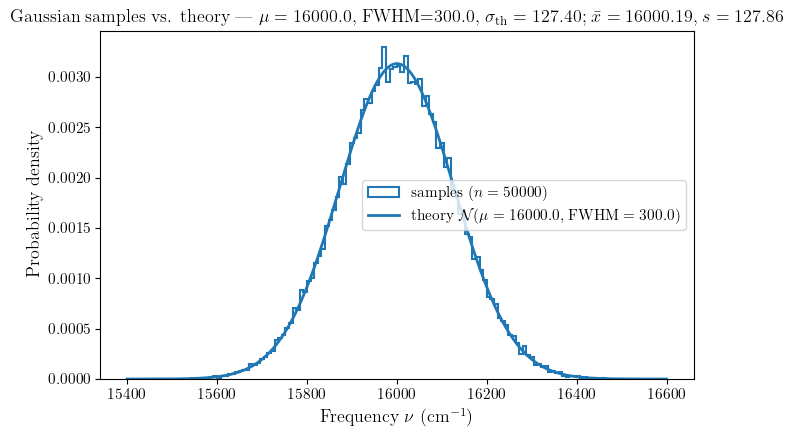

Samples shape (n_samples, n_centers): (20000, 4)
Means per center: [15100.22 15300.28 15498.99 15700.28]
Stds  per center: [126.95 127.31 126.99 127.86]


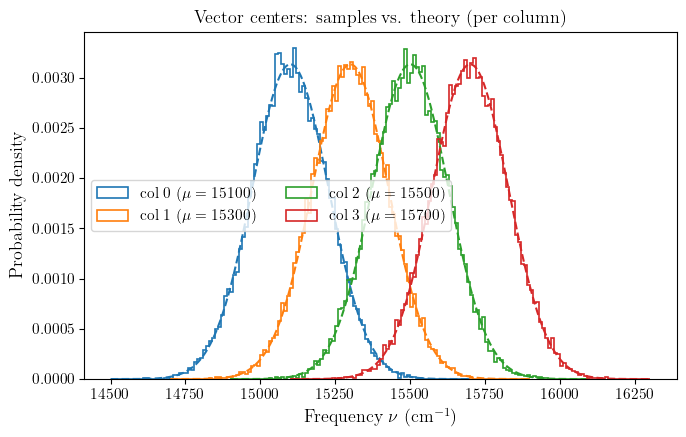

In [14]:
# Run a few visual checks for scalar and vector centers

# Scalar center
mu_scalar   = 16000.0  # cm^-1
fwhm_scalar = 300.0     # cm^-1
_ = plot_gaussian_check(mu_scalar, fwhm_scalar, n_samples=50_000, bins=150)
plt.tight_layout()
plt.show()

# Vector centers (multiple atoms); check shape and per-column stats
centers = np.array([15_100.0, 15_300.0, 15_500.0, 15_700.0])
fwhm    = 300.0
ns      = 20_000
samples = sample_from_gaussian(ns, fwhm, centers)
print("Samples shape (n_samples, n_centers):", samples.shape)

means = samples.mean(axis=0)
stds  = samples.std(axis=0, ddof=1)
print("Means per center:", np.round(means, 2))
print("Stds  per center:", np.round(stds, 2))

# Overlay histograms for a couple of columns
fig, ax = plt.subplots(figsize=(7, 4.5))
for i, c in enumerate(centers):
    x   = np.linspace(c - 2*fwhm, c + 2*fwhm, 600)
    ax.hist(samples[:, i], bins=120, range=(c - 2*fwhm, c + 2*fwhm), density=True,
            histtype="step", color=COLORS[i], linewidth=1.2, label=rf"col {i} ($\mu={c:.0f}$)")
    ax.plot(x, normalized_gauss(x, fwhm=fwhm, mu=c), color=COLORS[i], linestyle="dashed")

ax.set_xlabel(r"Frequency $\nu$ (cm$^{-1}$)")
ax.set_ylabel(r"Probability density")
ax.set_title(r"Vector centers: samples vs. theory (per column)")
ax.legend(ncol=2)
plt.tight_layout()
plt.show()

In [16]:
from qspectro2d.spectroscopy.inhomogenity import sample_from_gaussian
import numpy as np

base = np.array([12100.0, 12300.0, 12500.0])
delta = 100.0
ns    = 10_000

S = sample_from_gaussian(ns, delta, base)
print(S.shape)                  # (10000, 3)
print(np.round(S.mean(0), 1))   # close to base
print(np.round(S.std(0), 1))    # ~ delta/(2*sqrt(2*ln2))

(10000, 3)
[12100.4 12300.4 12500.1]
[41.9 42.5 42.5]


In [15]:
### Does the inhomogeneous broadening actually influences the Hamiltonian?? 

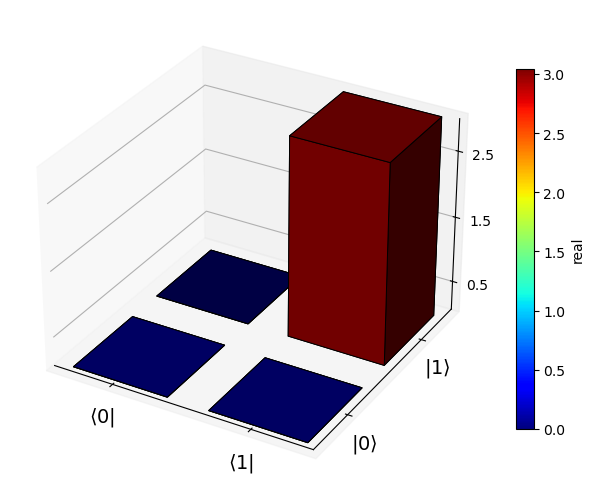

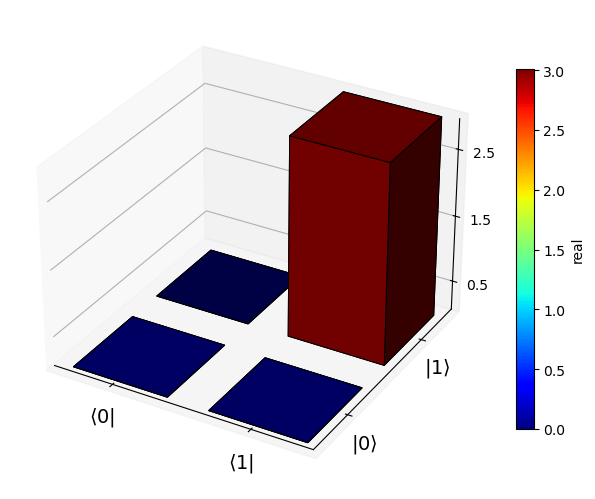

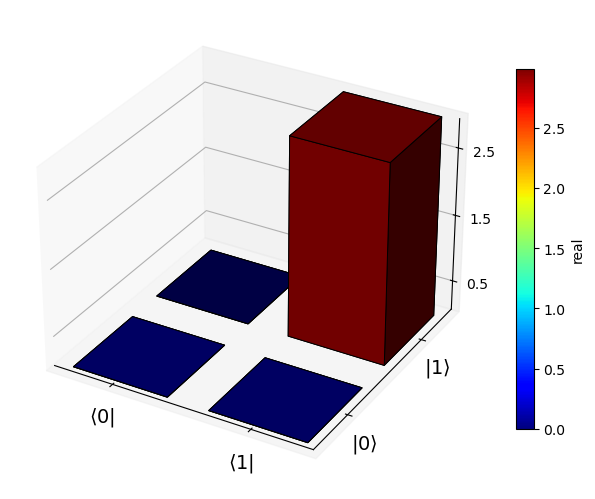

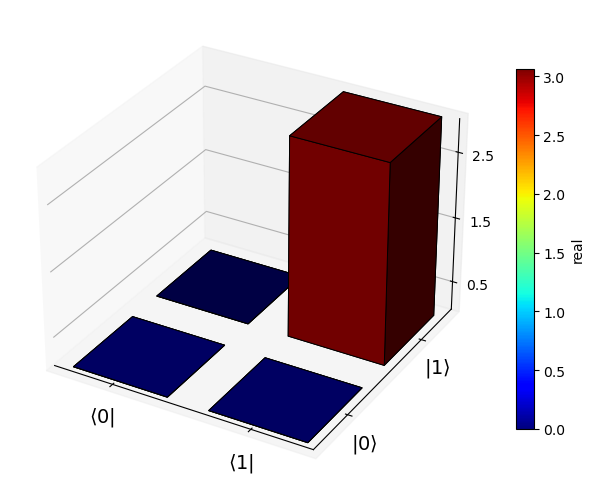

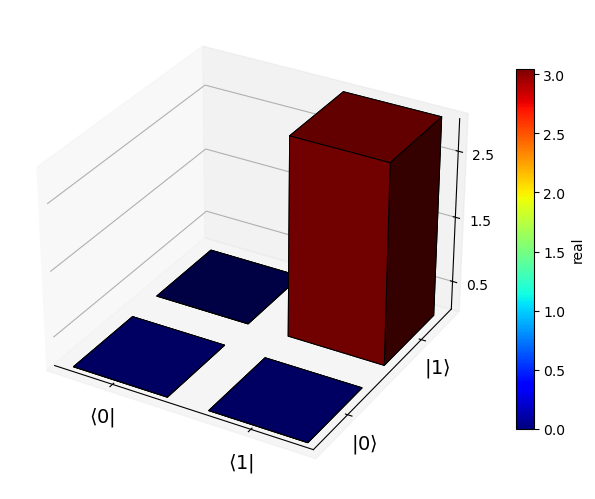

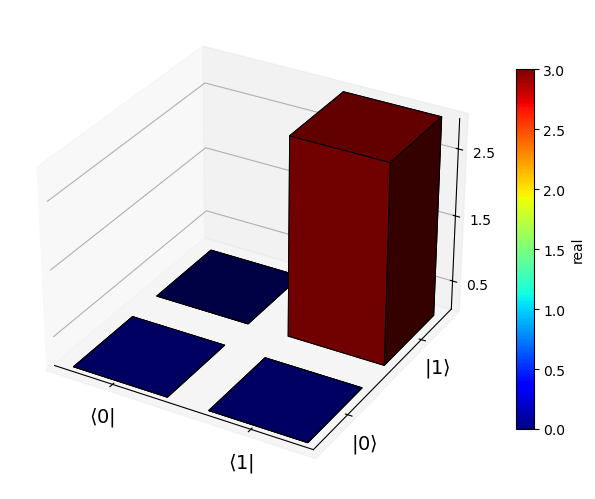

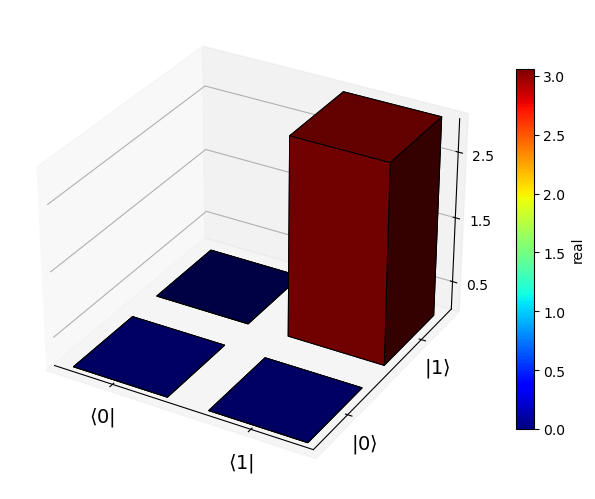

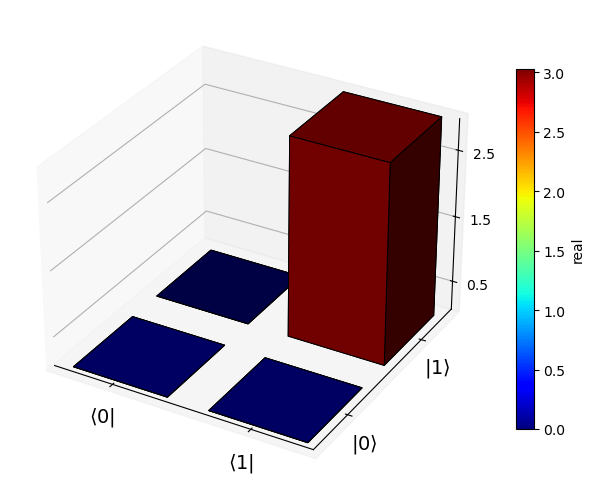

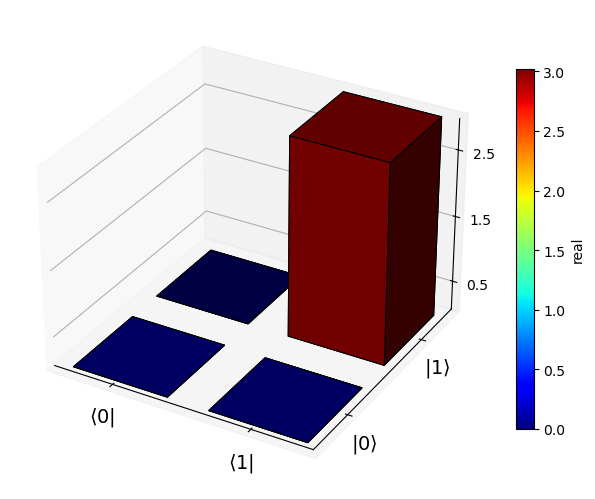

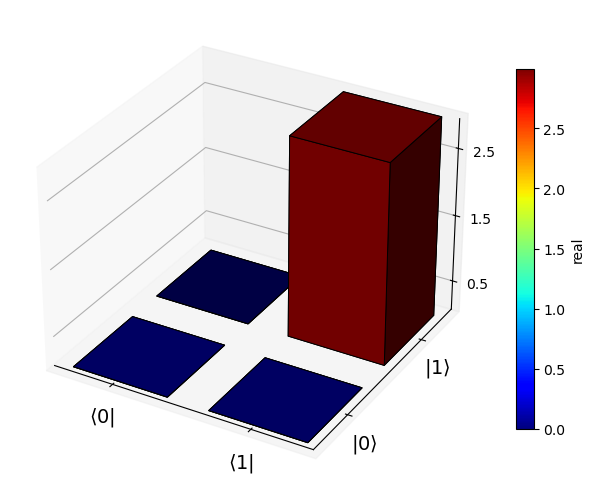

In [19]:
from qutip import matrix_histogram
from qspectro2d.core.atomic_system import AtomicSystem
from qspectro2d.spectroscopy.inhomogenity import sample_from_gaussian
sys = AtomicSystem(
    n_atoms=1,
    dip_moments=[1.0],
    frequencies_cm=[16000.0],
    delta_inhomogen_cm=300.0,
)
sys.frequencies_cm
n_inhomogen = 10

freqs = sample_from_gaussian(n_inhomogen, sys.delta_inhomogen_cm, sys.frequencies_cm)
for f in freqs:
    sys.update_frequencies_cm(f)
    H = sys.hamiltonian
matrix_histogram(H)

In [ ]:
# Diagnostic: verify sampled frequencies propagate into Hamiltonian and eigenvalues
import numpy as np
from qspectro2d.core.atomic_system import AtomicSystem
from qspectro2d.spectroscopy.inhomogenity import sample_from_gaussian, _fwhm_to_sigma
from qspectro2d.utils import convert_cm_to_fs

# Parameters
base_freq_cm      = 16000.0
fwhm_cm           = 300.0
n_inhomogen       = 12  # keep small for speed

# Fresh system instance (avoid history side-effects)
sys_diag = AtomicSystem(
    n_atoms=1,
    dip_moments=[1.0],
    frequencies_cm=[base_freq_cm],
    delta_inhomogen_cm=fwhm_cm,
)

# Draw frequency samples (shape (n_inhomogen,))
samples_cm = sample_from_gaussian(n_inhomogen, fwhm_cm, base_freq_cm)
samples_cm = np.asarray(samples_cm, dtype=float).ravel()

record = []  # will store tuples (freq_cm, eigvals_fs, H_diag_elements_fs)

for i, nu_cm in enumerate(samples_cm):
    sys_diag.update_frequencies_cm([float(nu_cm)])
    H = sys_diag.hamiltonian          # Hamiltonian in (probably) energy units consistent with fs^-1 after conversion
    # Eigenvalues (should reflect updated transition frequency in excited state energy)
    eigvals = np.array(H.eigenenergies())
    # Extract diagonal (for monomer it's already diagonal after building eigenbasis)
    diag_vals = np.diag(H.full())
    record.append((nu_cm, eigvals.copy(), diag_vals.copy()))

# Convert sampled cm^-1 to fs^-1 using helper; for a 2-level system we expect excited-ground gap ~ convert_cm_to_fs(nu_cm)
converted_samples_fs = convert_cm_to_fs(samples_cm)

# Build arrays for analysis
freqs_cm_arr   = np.array([r[0] for r in record])
eig_gap_fs_arr = np.array([r[1][1] - r[1][0] for r in record])  # excited - ground

# Basic statistics
corr = np.corrcoef(converted_samples_fs, eig_gap_fs_arr)[0, 1]

print("Inhomogeneous frequency sampling diagnostics:")
print(f"  n_samples                : {n_inhomogen}")
print(f"  Base freq (cm^-1)        : {base_freq_cm}")
print(f"  FWHM (cm^-1)             : {fwhm_cm}")
print(f"  Sampled freq range (cm^-1): [{freqs_cm_arr.min():.1f}, {freqs_cm_arr.max():.1f}]")
print(f"  Eigen gap range (fs^-1)  : [{eig_gap_fs_arr.min():.5f}, {eig_gap_fs_arr.max():.5f}]")
print(f"  Pearson corr(sample_cm→eig_gap_fs): {corr:.6f}")

# Sanity check: differences between successive updates (should not all be zero)
unique_gaps = np.unique(np.round(eig_gap_fs_arr, 10))
print(f"  Unique eigen gaps count  : {unique_gaps.size}")
if unique_gaps.size == 1:
    print("  ❌ All eigen gaps identical -> frequency update NOT influencing Hamiltonian (investigate caching).")
else:
    print("  ✅ Eigen gaps vary with sampled frequencies.")

# Optional: quick textual table
print("\nSample_cm  eig_gap_fs  ratio(eig_gap / conv_cm_to_fs(sample_cm))")
for nu_cm, gap_fs in zip(freqs_cm_arr[:8], eig_gap_fs_arr[:8]):  # limit rows
    expected_fs = convert_cm_to_fs(nu_cm)
    print(f"{nu_cm:9.2f}  {gap_fs:10.5f}  {gap_fs/expected_fs:6.3f}")

# If desired you can assert correlation ~1.0
if corr < 0.999:
    print("  ⚠️ Correlation < 0.999: scaling or unit mismatch suspected.")

# NOTE:
# For a monomer Hamiltonian often H = diag(0, ω_eg). If additional shifts (e.g., RWA offsets) are applied elsewhere,
# comparison should be done before applying rotating-frame transformations.

Inhomogeneous frequency sampling diagnostics:
  n_samples                : 12
  Base freq (cm^-1)        : 16000.0
  FWHM (cm^-1)             : 300.0
  Sampled freq range (cm^-1): [15785.8, 16122.2]
  Eigen gap range (fs^-1)  : [2.97357, 3.03694]
  Pearson corr(sample_cm→eig_gap_fs): 1.000000
  Unique eigen gaps count  : 12
  ✅ Eigen gaps vary with sampled frequencies.

Sample_cm  eig_gap_fs  ratio(eig_gap / conv_cm_to_fs(sample_cm))
 16048.84     3.02312   1.000
 15900.07     2.99509   1.000
 15927.05     3.00018   1.000
 16092.00     3.03125   1.000
 16122.20     3.03694   1.000
 15831.90     2.98225   1.000
 15785.81     2.97357   1.000
 15997.19     3.01339   1.000


## test to see if it also affects the overall sim_obj

In [25]:
from qspectro2d.config import create_base_sim_oqs

test, _ = create_base_sim_oqs()


base_freq_cm      = 16000.0
fwhm_cm           = 300.0
n_inhomogen       = 12  # keep small for speed

# Fresh system instance (avoid history side-effects)
test.system.delta_inhomogen_cm = fwhm_cm
test.simulation_config.n_inhomogen = n_inhomogen
print("the current freqs are", test.system.frequencies_cm,
      "the current delta is", test.system.delta_inhomogen_cm,
      "the current n_inhomogen is", test.simulation_config.n_inhomogen
      )
# Draw frequency samples (shape (n_inhomogen,))
samples_cm = sample_from_gaussian(n_inhomogen, fwhm_cm, base_freq_cm)
samples_cm = np.asarray(samples_cm, dtype=float).ravel()

record = []  # will store tuples (freq_cm, eigvals_fs, H_diag_elements_fs)

for i, nu_cm in enumerate(samples_cm):
    test.system.update_frequencies_cm([float(nu_cm)])
    H = test.system.hamiltonian          # Hamiltonian in (probably) energy units consistent with fs^-1 after conversion
    # Eigenvalues (should reflect updated transition frequency in excited state energy)
    eigvals = np.array(H.eigenenergies())
    # Extract diagonal (for monomer it's already diagonal after building eigenbasis)
    diag_vals = np.diag(H.full())
    record.append((nu_cm, eigvals.copy(), diag_vals.copy()))

# Convert sampled cm^-1 to fs^-1 using helper; for a 2-level system we expect excited-ground gap ~ convert_cm_to_fs(nu_cm)
converted_samples_fs = convert_cm_to_fs(samples_cm)

# Build arrays for analysis
freqs_cm_arr   = np.array([r[0] for r in record])
eig_gap_fs_arr = np.array([r[1][1] - r[1][0] for r in record])  # excited - ground

# Basic statistics
corr = np.corrcoef(converted_samples_fs, eig_gap_fs_arr)[0, 1]

print("Inhomogeneous frequency sampling diagnostics:")
print(f"  n_samples                : {n_inhomogen}")
print(f"  Base freq (cm^-1)        : {base_freq_cm}")
print(f"  FWHM (cm^-1)             : {fwhm_cm}")
print(f"  Sampled freq range (cm^-1): [{freqs_cm_arr.min():.1f}, {freqs_cm_arr.max():.1f}]")
print(f"  Eigen gap range (fs^-1)  : [{eig_gap_fs_arr.min():.5f}, {eig_gap_fs_arr.max():.5f}]")
print(f"  Pearson corr(sample_cm→eig_gap_fs): {corr:.6f}")

# Sanity check: differences between successive updates (should not all be zero)
unique_gaps = np.unique(np.round(eig_gap_fs_arr, 10))
print(f"  Unique eigen gaps count  : {unique_gaps.size}")
if unique_gaps.size == 1:
    print("  ❌ All eigen gaps identical -> frequency update NOT influencing Hamiltonian (investigate caching).")
else:
    print("  ✅ Eigen gaps vary with sampled frequencies.")

# Optional: quick textual table
print("\nSample_cm  eig_gap_fs  ratio(eig_gap / conv_cm_to_fs(sample_cm))")
for nu_cm, gap_fs in zip(freqs_cm_arr[:8], eig_gap_fs_arr[:8]):  # limit rows
    expected_fs = convert_cm_to_fs(nu_cm)
    print(f"{nu_cm:9.2f}  {gap_fs:10.5f}  {gap_fs/expected_fs:6.3f}")

# If desired you can assert correlation ~1.0
if corr < 0.999:
    print("  ⚠️ Correlation < 0.999: scaling or unit mismatch suspected.")

# NOTE:
# For a monomer Hamiltonian often H = diag(0, ω_eg). If additional shifts (e.g., RWA offsets) are applied elsewhere,
# comparison should be done before applying rotating-frame transformations.

🔧 Configured to use max_workers=12 for parallel tasks.
🔧 Base simulation created from config (overrides applied early).
🔍 Validating solver...
=== SOLVER DIAGNOSTICS ===
Solver: BR
Time range: t0=-30.000, t_max=40.000, dt=1.000000
Number of time points: 71
RWA enabled: True
=== SYSTEM DIAGNOSTICS ===
Initial state type, shape, is hermitian, trace: <class 'qutip.core.qobj.Qobj'>, (2, 2), True, 1.000000
Initial eigenvalues range: [0.000000, 1.000000]
Initial min eigenvalue: 0.0000000000
Total Hamiltonian dims: [[2], [2]]
Total Hamiltonian type: <class 'qutip.core.cy.qobjevo.QobjEvo'>
Number of decay channels: 2
🔧 Base simulation created from config (overrides applied early).
🔍 Validating solver...
=== SOLVER DIAGNOSTICS ===
Solver: BR
Time range: t0=-30.000, t_max=40.000, dt=1.000000
Number of time points: 71
RWA enabled: True
=== SYSTEM DIAGNOSTICS ===
Initial state type, shape, is hermitian, trace: <class 'qutip.core.qobj.Qobj'>, (2, 2), True, 1.000000
Initial eigenvalues range: [0.000